# Issues with temperature and buoyancy resolved

October 8th. Current overview of calculations is given below.

### Exner function
`exner = (p_level / p_0) ** (R_d / c_p)`

### Temperature
`T = theta_l * exner + (L_v * l_level) / c_p`

### Potential temperature
`theta = T / exner`

### Virtual temperature
`theta_v = theta * (1 + ep2 * q_v - l_level)`

### Reference virtual temperature
```
lw_threshold = 1e-5
non_cloudy_mask = l_level < lw_threshold

if np.any(non_cloudy_mask):
    theta_v_0 = np.mean(theta_v[non_cloudy_mask])
else:
    # Fallback: Use the mean of theta over the entire level
    theta_v_0 = np.mean(theta_v)
```

### Buoyancy 
`B =  g * ((theta_v / theta_v_0) - 1)`


Remnant of the old calculation below

In [ ]:
# timestep = 20      # Specify the timestep you want to extract
# height_index = 45   # Index of the height level you want to extract

# # Select the height level
# t_level = t[height_index, :, :]
# q_level = q[height_index, :, :]
# l_level = l[height_index, :, :]
# p_level = p[height_index, :, :]
# w_level = w[height_index, :, :]  # Vertical velocity at the specified height

# # Compute q_v (Vapor Mixing Ratio)
# q_v = q_level - l_level

# # Compute θ_l (Liquid Water Potential Temperature)
# theta_l = t_level

# # Exner function
# cpr = R_d / c_p
# exner = (p_level / p_0) ** cpr

# # Compute temperature T
# T = theta_l * exner + (L_v * l_level) / c_p

# # Compute full potential temperature θ
# theta = T / exner

# # Create a mask for non-cloudy areas
# lw_threshold = 1e-5
# non_cloudy_mask = l_level < lw_threshold

# # Compute virtual temperature
# theta_v = theta * (1 + ep2 * q_v - l_level)

# # Compute reference virtual temperature over non-cloudy areas
# if np.any(non_cloudy_mask):
#     theta_v_0 = np.mean(theta_v[non_cloudy_mask])
# else:
#     # Fallback: Use the mean of theta over the entire level
#     theta_v_0 = np.mean(theta_v)
#     print("Warning: No non-cloudy areas found at this level. Using mean theta over the entire level.")

# # Compute Buoyancy
# B =  g * ((theta_v / theta_v_0) - 1)

# Overview of datasets

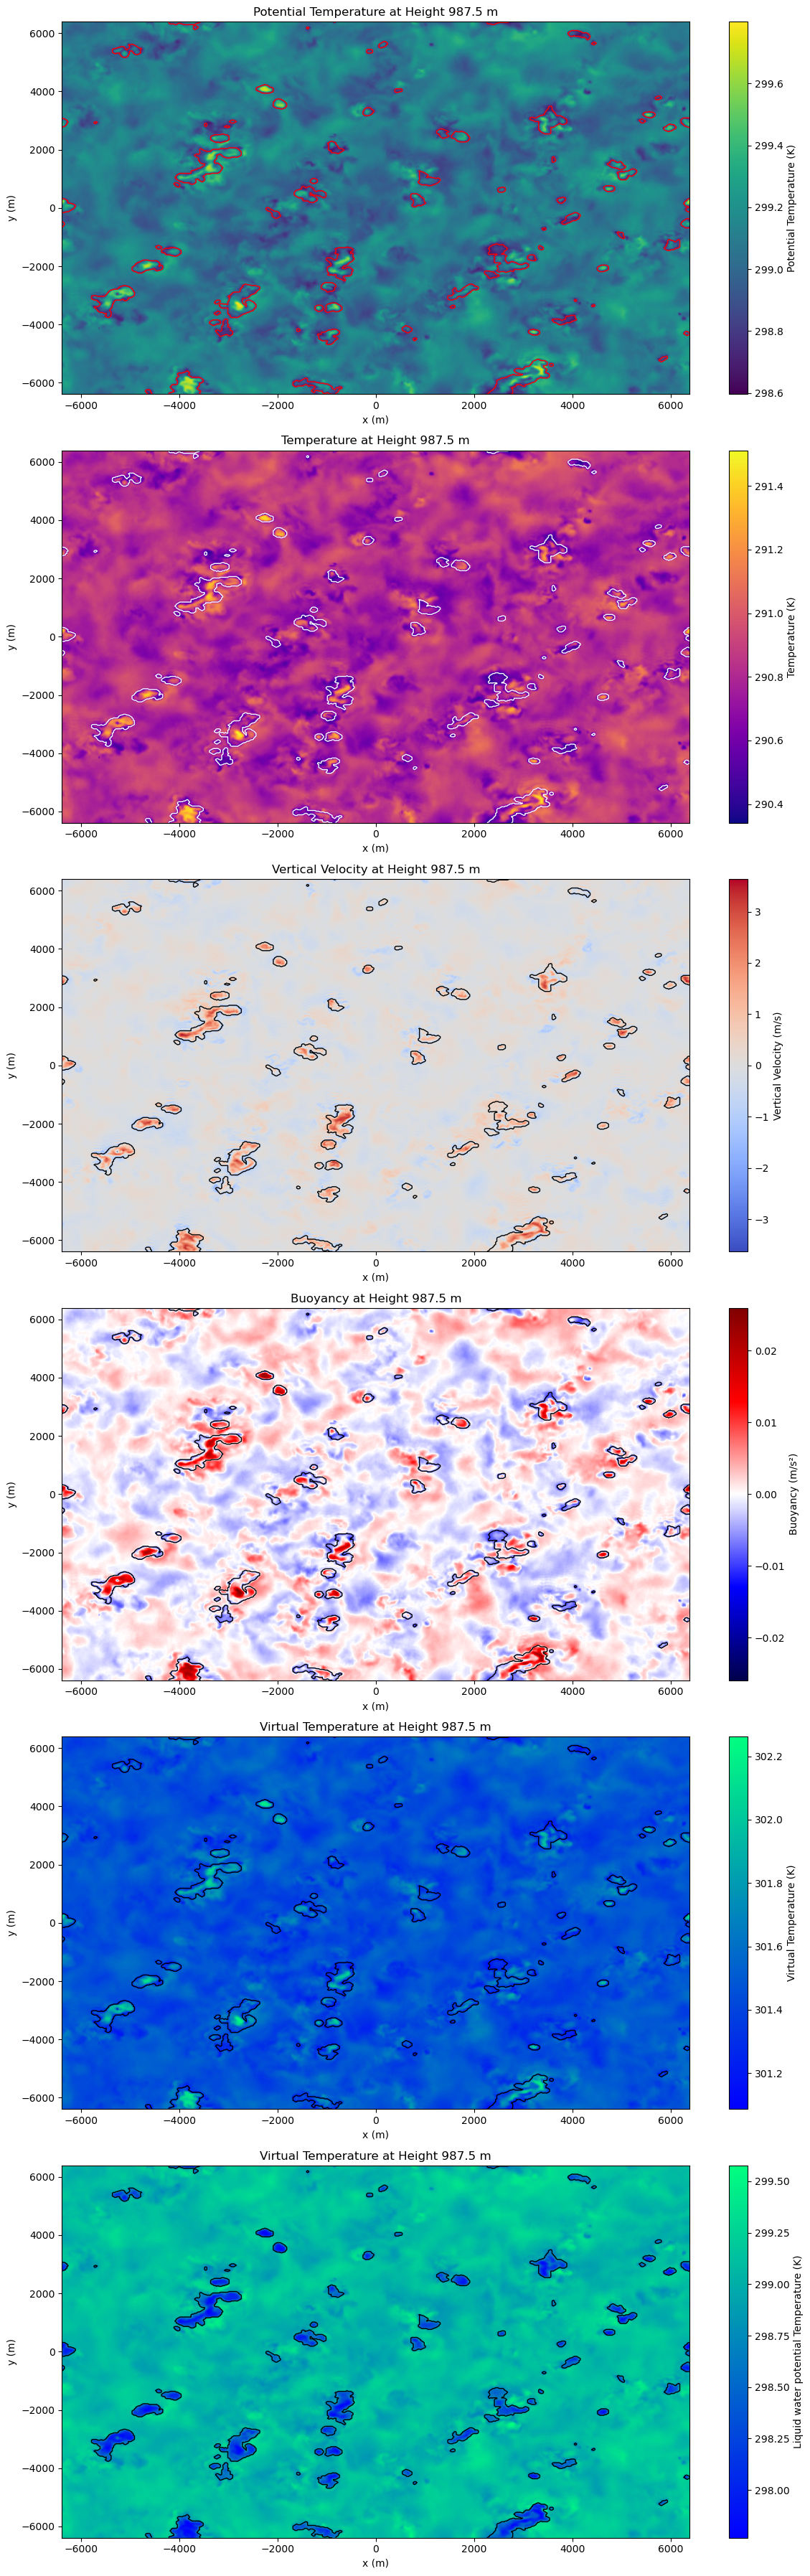

In [13]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

lw_threshold = 1e-6

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

def load_xy_values(filename):
    with nc.Dataset(filename) as ds:
        x_values = ds['xt'][:]
        y_values = ds['yt'][:]
    return x_values, y_values

# File paths (Update these paths to match your file locations)
temp_file = '/Users/jure/PhD/coding/RICO_1hr/rico.temp.nc'           # Temperature file
potential_temp_file = '/Users/jure/PhD/coding/RICO_1hr/rico.potential_temp.nc'  # Potential Temperature file
virtual_temp_file = '/Users/jure/PhD/coding/RICO_1hr/rico.virtual_temp.nc'      # Virtual Temperature file
buoyancy_file = '/Users/jure/PhD/coding/RICO_1hr/rico.buoyancy.nc'              # Buoyancy file
w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'                # Vertical velocity file
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'                # Liquid water content file
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'                # Pressure file
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'                # Liquid water potential temperature file

timestep = 15       # Specify the timestep you want to extract
height_index = 40   # Index of the height level you want to extract

# Load data from NetCDF files
T = load_data_all_levels(temp_file, 'temperature', timestep)
theta = load_data_all_levels(potential_temp_file, 'potential_temperature', timestep)
theta_v = load_data_all_levels(virtual_temp_file, 'virtual_temperature', timestep)
theta_l = load_data_all_levels(t_file, 't', timestep)
B = load_data_all_levels(buoyancy_file, 'buoyancy', timestep)
w = load_data_all_levels(w_file, 'w', timestep)
l = load_data_all_levels(l_file, 'l', timestep)
p = load_data_all_levels(p_file, 'p', timestep)


# Load zt, x, y values
zt = load_zt_values(p_file)  # Assuming zt is the same in all files
x_values, y_values = load_xy_values(p_file)

# Select the height level
T_level = T[height_index, :, :]
theta_level = theta[height_index, :, :]
theta_v_level = theta_v[height_index, :, :]
theta_l_level = theta_l[height_index, :, :]
B_level = B[height_index, :, :]
w_level = w[height_index, :, :]
l_level = l[height_index, :, :]
p_level = p[height_index, :, :]


# Create a figure with five subplots
fig, axs = plt.subplots(6, 1, figsize=(12, 36))  # 5 rows, 1 column

# Plotting Potential Temperature θ
im0 = axs[0].imshow(
    theta_level.T, origin='lower',
    extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()],
    aspect='auto', cmap='viridis')
fig.colorbar(im0, ax=axs[0], label='Potential Temperature (K)')
axs[0].set_title(f'Potential Temperature at Height {zt[height_index]:.1f} m')
axs[0].set_xlabel('x (m)')
axs[0].set_ylabel('y (m)')
contour_levels = [lw_threshold]
cs0_contour = axs[0].contour(x_values, y_values, l_level.T, levels=contour_levels, colors='red', linewidths=1)

# Plotting Temperature T
im1 = axs[1].imshow(
    T_level.T, origin='lower',
    extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()],
    aspect='auto', cmap='plasma')
fig.colorbar(im1, ax=axs[1], label='Temperature (K)')
axs[1].set_title(f'Temperature at Height {zt[height_index]:.1f} m')
axs[1].set_xlabel('x (m)')
axs[1].set_ylabel('y (m)')
cs1_contour = axs[1].contour(x_values, y_values, l_level.T, levels=contour_levels, colors='white', linewidths=1)

# Plotting Vertical Velocity w
w_abs_max = max(abs(np.min(w_level)), abs(np.max(w_level)))  # Define limits to center around 0
im2 = axs[2].imshow(
    w_level.T, origin='lower',
    extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()],
    aspect='auto', cmap='coolwarm', vmin=-w_abs_max, vmax=w_abs_max)
fig.colorbar(im2, ax=axs[2], label='Vertical Velocity (m/s)')
axs[2].set_title(f'Vertical Velocity at Height {zt[height_index]:.1f} m')
axs[2].set_xlabel('x (m)')
axs[2].set_ylabel('y (m)')
cs2_contour = axs[2].contour(x_values, y_values, l_level.T, levels=contour_levels, colors='black', linewidths=1)

# Plotting Buoyancy B
B_abs_max = max(abs(np.min(B_level)), abs(np.max(B_level)))  # Define limits to center around 0
im3 = axs[3].imshow(
    B_level.T, origin='lower',
    extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()],
    aspect='auto', cmap='seismic', vmin=-B_abs_max, vmax=B_abs_max)
fig.colorbar(im3, ax=axs[3], label='Buoyancy (m/s²)')
axs[3].set_title(f'Buoyancy at Height {zt[height_index]:.1f} m')
axs[3].set_xlabel('x (m)')
axs[3].set_ylabel('y (m)')
cs3_contour = axs[3].contour(x_values, y_values, l_level.T, levels=contour_levels, colors='black', linewidths=1)

# Plotting Virtual Temperature θ_v
im4 = axs[4].imshow(
    theta_v_level.T, origin='lower',
    extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()],
    aspect='auto', cmap='winter')
fig.colorbar(im4, ax=axs[4], label='Virtual Temperature (K)')
axs[4].set_title(f'Virtual Temperature at Height {zt[height_index]:.1f} m')
axs[4].set_xlabel('x (m)')
axs[4].set_ylabel('y (m)')
cs4_contour = axs[4].contour(x_values, y_values, l_level.T, levels=contour_levels, colors='black', linewidths=1)

# Plotting Virtual Temperature θ_v
im5 = axs[5].imshow(
    theta_l_level.T, origin='lower',
    extent=[x_values.min(), x_values.max(), y_values.min(), y_values.max()],
    aspect='auto', cmap='winter')
fig.colorbar(im5, ax=axs[5], label='Liquid Water Potential Temperature (K)')
axs[5].set_title(f'Liquid Water Potential Temperature at Height {zt[height_index]:.1f} m')
axs[5].set_xlabel('x (m)')
axs[5].set_ylabel('y (m)')
cs5_contour = axs[5].contour(x_values, y_values, l_level.T, levels=contour_levels, colors='black', linewidths=1)

plt.tight_layout()
# plt.savefig('new_temp_and_buoyancy.pdf', format='pdf', bbox_inches='tight')
plt.show()


# Distance from cloud edge


Processing timestep 1...
Processing timestep 2...
Processing timestep 3...
Processing timestep 4...
Processing timestep 5...
Processing timestep 6...
Processing timestep 7...
Processing timestep 8...
Processing timestep 9...
Processing timestep 10...
Processing timestep 11...
Processing timestep 12...
Processing timestep 13...
Processing timestep 14...
Processing timestep 15...
Processing timestep 16...
Processing timestep 17...
Processing timestep 18...


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_83346/956410210.py:112: RuntimeWarning: Mean of empty slice
  mean_results[key] = np.nanmean(stacked_arrays, axis=0)


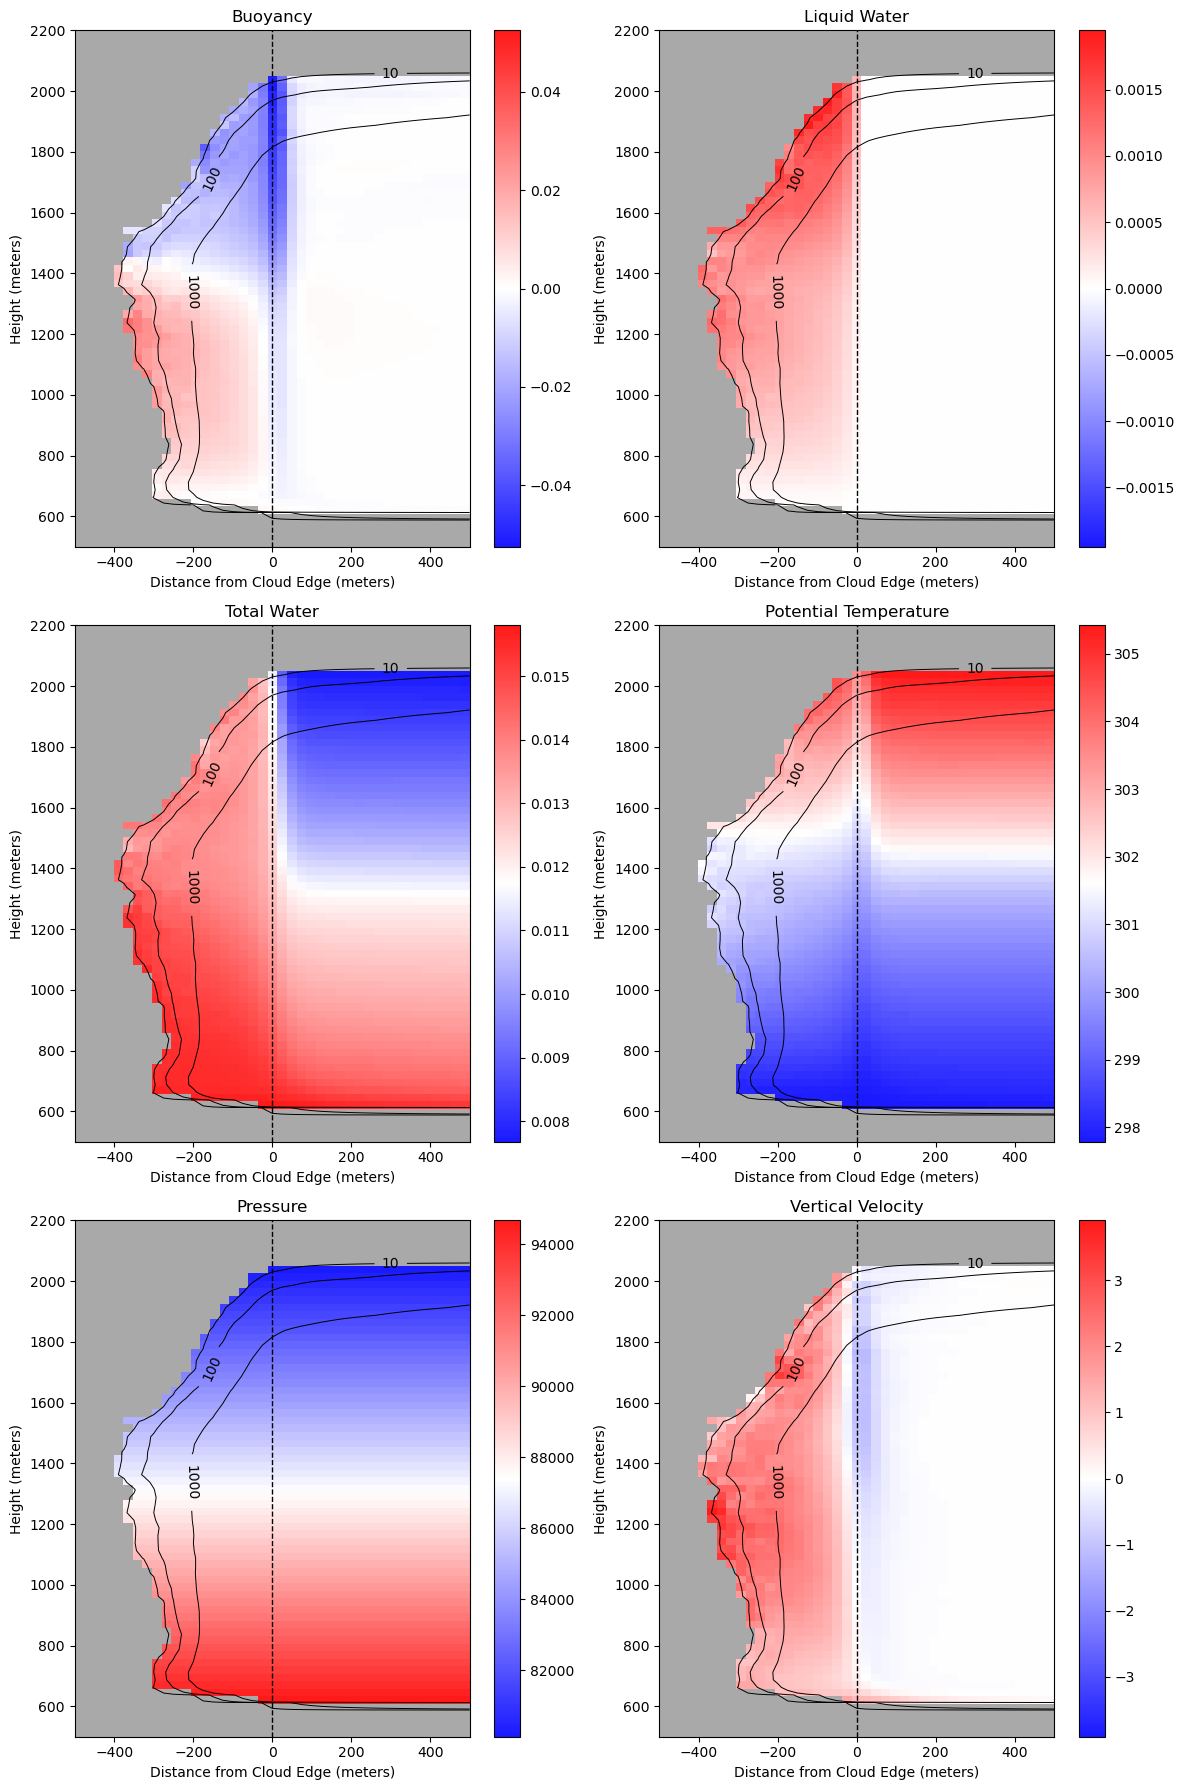

In [16]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_cdt
from matplotlib.colors import Normalize, ListedColormap

horizontal_resolution = 25  # Horizontal resolution in meters

w_file = '/Users/jure/PhD/coding/RICO_1hr/rico.w.nc'                   # Vertical velocity
l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.l.nc'                   # Liquid water mixing ratio
q_file = '/Users/jure/PhD/coding/RICO_1hr/rico.q.nc'                   # Total water mixing ratio
t_file = '/Users/jure/PhD/coding/RICO_1hr/rico.t.nc'                   # Liquid Water Potential Temperature
p_file = '/Users/jure/PhD/coding/RICO_1hr/rico.p.nc'                   # Pressure
buoyancy_file = '/Users/jure/PhD/coding/RICO_1hr/rico.buoyancy.nc'     # Buoyancy
theta_l_file = '/Users/jure/PhD/coding/RICO_1hr/rico.potential_temp.nc'  # Potential Temperature

def load_data_all_levels(filename, var_name, timestep):
    with nc.Dataset(filename) as ds:
        data = ds[var_name][timestep, :, :, :]  # Extract all levels for the timestep
        if var_name in ['l', 'q']:
            data = data  # Convert from g/kg to kg/kg if necessary
    return data

def load_zt_values(filename):
    with nc.Dataset(filename) as ds:
        zt_values = ds['zt'][:]
    return zt_values

def calculate_values_vs_distance(
    buoyancy_data, liquid_water_data, total_water_data, theta_l_data,
    pressure_data, w_data, cloud_mask, max_distance):
    """Calculate values as a function of distance from cloud edge for various variables."""
    height_levels = buoyancy_data.shape[0]
    total_distance = max_distance * 2 + 1  # Negative to positive distances
    results = {
        'buoyancy': np.full((height_levels, total_distance), np.nan),
        'liquid_water': np.full((height_levels, total_distance), np.nan),
        'total_water': np.full((height_levels, total_distance), np.nan),
        'theta_l': np.full((height_levels, total_distance), np.nan),
        'pressure': np.full((height_levels, total_distance), np.nan),
        'w': np.full((height_levels, total_distance), np.nan),
        'cloud_count': np.zeros((height_levels, total_distance), dtype=int)
    }

    for z in range(height_levels):
        region_cloud_mask = cloud_mask[z]

        # Only proceed if there are clouds at this height level
        if np.any(region_cloud_mask):
            # Compute distances inside the cloud and shift so cloud edge is distance 0
            distance_inward = distance_transform_cdt(region_cloud_mask, metric='taxicab')
            distances_inside = -distance_inward + 1  # Shift distances so cloud edge is at 0

            # Compute distances outside the cloud
            distance_outward = distance_transform_cdt(~region_cloud_mask, metric='taxicab')
            distances_outside = distance_outward

            # Combine distances
            distances = np.full(region_cloud_mask.shape, np.nan)
            distances[region_cloud_mask] = distances_inside[region_cloud_mask]
            distances[~region_cloud_mask] = distances_outside[~region_cloud_mask]

            # Convert distances to integer type
            distances = distances.astype(int)

            # Calculate each variable for each distance
            for distance in range(-max_distance, max_distance + 1):
                indices = np.where(distances == distance)
                if len(indices[0]) > 0:
                    idx_z = z
                    idx_d = distance + max_distance  # Adjust index for negative distances
                    results['buoyancy'][idx_z, idx_d] = np.mean(buoyancy_data[idx_z, indices[0], indices[1]])
                    results['liquid_water'][idx_z, idx_d] = np.mean(liquid_water_data[idx_z, indices[0], indices[1]])
                    results['total_water'][idx_z, idx_d] = np.mean(total_water_data[idx_z, indices[0], indices[1]])
                    results['theta_l'][idx_z, idx_d] = np.mean(theta_l_data[idx_z, indices[0], indices[1]])
                    results['pressure'][idx_z, idx_d] = np.mean(pressure_data[idx_z, indices[0], indices[1]])
                    results['w'][idx_z, idx_d] = np.mean(w_data[idx_z, indices[0], indices[1]])
                    results['cloud_count'][idx_z, idx_d] += len(indices[0])

    return results


def process_multiple_timesteps_with_edge(timesteps, max_distance):
    all_results = []

    for timestep in timesteps:
        print(f"Processing timestep {timestep}...")
        theta_l_data = load_data_all_levels(theta_l_file, 'potential_temperature', timestep)
        p_data = load_data_all_levels(p_file, 'p', timestep)
        q_t_data = load_data_all_levels(q_file, 'q', timestep)
        q_l_data = load_data_all_levels(l_file, 'l', timestep)
        w_data = load_data_all_levels(w_file, 'w', timestep)
        buoyancy_data = load_data_all_levels(buoyancy_file, 'buoyancy', timestep)

        # Create a cloud mask based on the liquid water threshold
        cloud_mask = q_l_data > 1e-6  # Adjust the threshold as needed

        # Calculate values for each variable as a function of distance from the cloud edge
        results = calculate_values_vs_distance(
            buoyancy_data, q_l_data, q_t_data, theta_l_data, p_data, w_data, cloud_mask, max_distance)
        all_results.append(results)

    # Initialize mean_results to accumulate the data
    mean_results = {}

    # Combine results across timesteps
    for key in all_results[0].keys():
        if key == 'cloud_count':
            mean_results[key] = np.nansum([result[key] for result in all_results], axis=0)
        else:
            stacked_arrays = np.array([result[key] for result in all_results])
            mean_results[key] = np.nanmean(stacked_arrays, axis=0)

    return mean_results

# Parameters for distance and resolution
timesteps = list(range(1, 19))  # Adjust the range as needed
max_distance_in_meters = 500    # Maximum distance from cloud edge in meters
max_distance = max_distance_in_meters // horizontal_resolution  # Convert to grid points

# Run the calculation
mean_results = process_multiple_timesteps_with_edge(timesteps, max_distance)

# Create distances in meters
distance_in_meters = np.arange(-max_distance, max_distance + 1) * horizontal_resolution

# Load height levels in meters
zt_values = load_zt_values(t_file)

# Define custom contour levels
custom_contour_levels = np.array([10, 100, 1000])  # Modify as needed

# Plotting multiple variables (3 rows, 2 columns)
fig, axs = plt.subplots(3, 2, figsize=(12, 18))
variables = ['buoyancy', 'liquid_water', 'total_water', 'theta_l', 'pressure', 'w']
titles = ['Buoyancy', 'Liquid Water', 'Total Water', 'Potential Temperature', 'Pressure', 'Vertical Velocity']

for ax, var, title in zip(axs.flat, variables, titles):
    data = np.ma.masked_invalid(mean_results[var])

    # Modify colormap
    cmap = plt.get_cmap('bwr')
    cmap = cmap(np.arange(cmap.N))
    cmap[:, -1] = 0.9  # Set alpha
    cmap = ListedColormap(cmap)
    cmap.set_bad(color='darkgrey')

    # Adjust the color bar
    data_min, data_max = np.nanmin(data), np.nanmax(data)
    if var in ['total_water', 'theta_l', 'pressure']:
        norm = Normalize(vmin=data_min, vmax=data_max)
    else:
        norm = Normalize(vmin=-np.nanmax(np.abs(data)), vmax=np.nanmax(np.abs(data)))

    # Plot the data
    im = ax.imshow(
        data, cmap=cmap, norm=norm, origin='lower', aspect='auto',
        extent=[distance_in_meters[0], distance_in_meters[-1], zt_values[0], zt_values[-1]])
    ax.set_title(title)
    ax.set_xlabel('Distance from Cloud Edge (meters)')
    ax.set_ylabel('Height (meters)')
    ax.set_ylim(500, 2200)  # Adjust height limits as needed
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1, label='Cloud Edge')

    # Add color bar
    fig.colorbar(im, ax=ax)

    # Overlay cloud count as contour
    cloud_count = mean_results['cloud_count']
    if custom_contour_levels is not None:
        levels = custom_contour_levels
    else:
        levels = np.linspace(np.min(cloud_count), np.max(cloud_count), 10)
    cs = ax.contour(
        distance_in_meters, zt_values, cloud_count, levels=levels, colors='black', linewidths=0.7)
    ax.clabel(cs, fmt='%d')

plt.tight_layout()
#plt.savefig('near_environment.pdf', format='pdf', bbox_inches='tight')
plt.show()


## Normalised distance

In [41]:
#  Needs to be done!

## Difference between cloud and environment
Mean cloud value at given height minus the value of a point.
todo: should be done as in-cloud average for each cloud and minus it and then average it. 

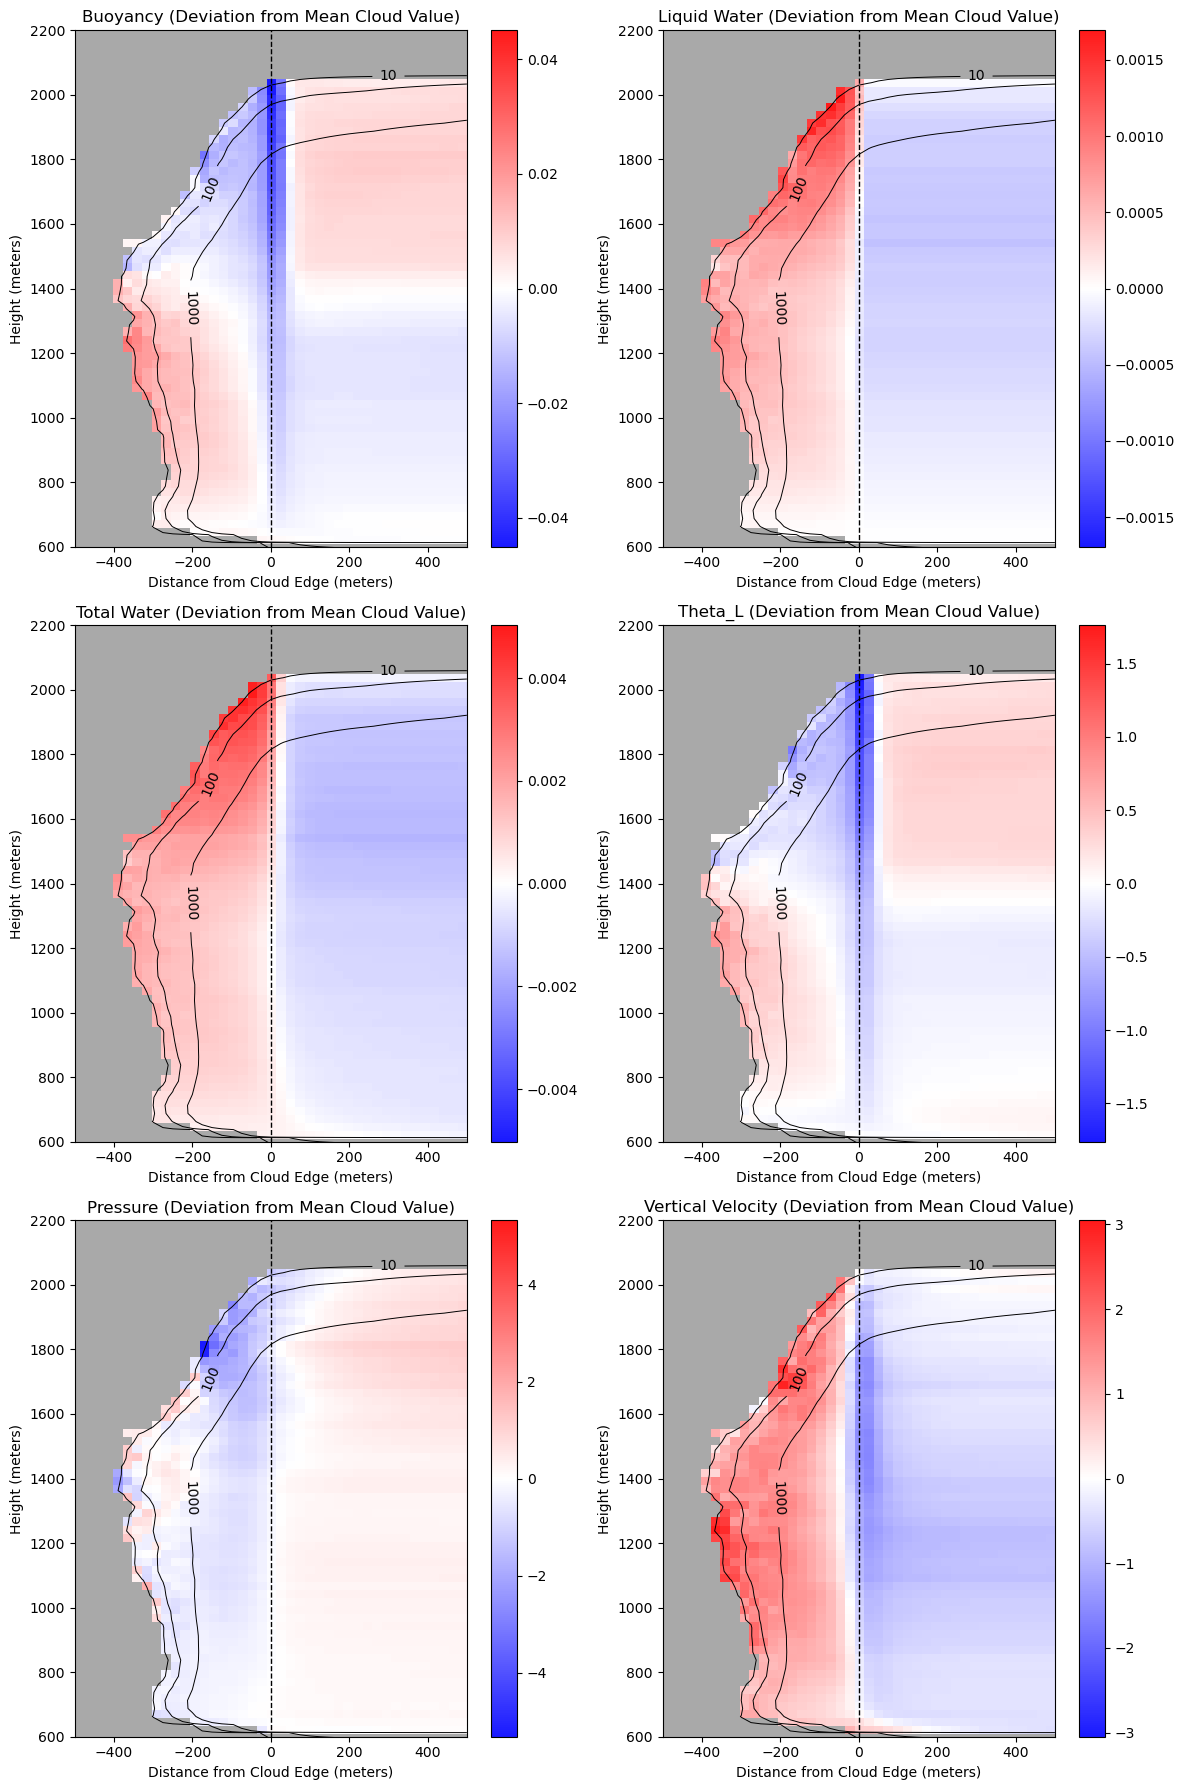

In [17]:
# Define custom contour levels for cloud count (you can modify these)
custom_contour_levels = np.array([10, 100, 1000])  # Example: focus on lower numbers

# Plotting multiple variables (3 rows, 2 columns)
fig, axs = plt.subplots(3, 2, figsize=(12, 18))
variables = ['buoyancy', 'liquid_water', 'total_water', 'theta_l', 'pressure', 'w']
titles = ['Buoyancy', 'Liquid Water', 'Total Water', 'Theta_L', 'Pressure', 'Vertical Velocity']

for ax, var, title in zip(axs.flat, variables, titles):
    data = np.ma.masked_invalid(mean_results[var])
    
    # Calculate the mean cloud value for each height level
    mean_cloud_values = np.zeros(data.shape[0])
    for z in range(data.shape[0]):
        cloud_points = data[z, :]  # All points at this height level
        cloud_mask_at_z = ~np.isnan(cloud_points)  # Use non-NaN values as cloud points
        if np.any(cloud_mask_at_z):
            mean_cloud_values[z] = np.nanmean(cloud_points[cloud_mask_at_z])
        else:
            mean_cloud_values[z] = np.nan  # No cloud points at this height

    # Subtract the mean cloud value at each height level from all points at that height
    for z in range(data.shape[0]):
        data[z, :] -= mean_cloud_values[z]
    
    # Modify colormap for each plot
    cmap = plt.get_cmap('bwr')
    cmap = cmap(np.arange(cmap.N))
    cmap[:, -1] = 0.9  # Set alpha to 0.9 for all colors (transparency)
    cmap = ListedColormap(cmap)
    cmap.set_bad(color='darkgrey')

    # Adjust the color bar to emphasize 0 and use the actual data range
    data_min, data_max = np.nanmin(data), np.nanmax(data)
    data_abs_max = max(abs(data_min), abs(data_max))
    norm = Normalize(vmin=-data_abs_max, vmax=data_abs_max)
    
    # Plot the data
    im = ax.imshow(data, cmap=cmap, norm=norm, origin='lower', aspect='auto',
                   extent=[distance_in_meters[0], distance_in_meters[-1], zt_values[0], zt_values[-1]])
    ax.set_title(f"{title} (Deviation from Mean Cloud Value)")
    ax.set_xlabel('Distance from Cloud Edge (meters)')
    ax.set_ylabel('Height (meters)')
    
    # Set the y-axis limit between 500 and 2200 meters
    ax.set_ylim(600, 2200)
    
    # Add a vertical line at x=0 to denote the cloud edge
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1, label='Cloud Edge')
    
    # Add color bar for each subplot
    fig.colorbar(im, ax=ax)

    # Overlay cloud count as contour
    cloud_count = mean_results['cloud_count']  # Access the cloud count data
    
    # Check if custom contour levels are provided
    if custom_contour_levels is not None:
        levels = custom_contour_levels  # Use the custom levels
    else:
        levels = np.linspace(np.min(cloud_count), np.max(cloud_count), 10)  # Default to 10 evenly spaced levels
    
    # Plot the contour with the chosen levels
    cs = ax.contour(distance_in_meters, zt_values, cloud_count, levels=levels, colors='black', linewidths=0.7)
    ax.clabel(cs, fmt='%d')  # Label contour lines with numbers

# Display the plot
plt.tight_layout()
#plt.savefig('near_environment_difference.pdf', format='pdf')
plt.show()
